# Detect disturbed tress

## Packages and Data

In [ ]:
import os
import sys

module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

from utils.data_loader import DataLoader
from utils.calculate_indices import CalculateIndices
from utils.preprocessing import Preprocessing
from utils.visualization_utils.visualization_time_series import plot_timeseries_oneid
from utils.correlation_analysis import CorrelationAnalysis

from src.preprocessing.preprocessing_steps.detect_disturbed_trees import DetectDisturbedTrees

from utils.constants import spectral_bands, indices
bands_and_indices = spectral_bands + indices

In [18]:
dataloader = DataLoader()
df_base = dataloader.load_transform("../data/Trainings_Datensatz.csv")
df = dataloader.date_feature_extraction(df_base)
df = dataloader.feature_extraction(df)

df = Preprocessing.interpolate_b4(df, method="linear")

calculateindices = CalculateIndices()
df = calculateindices.add_all_indices(df)

disturbed_detector = DetectDisturbedTrees()

## Idea and Approach 

*How to identifying Sick Trees (Not Labeled as “Disturbed”)?*

**1. Identify features that can indicate tree disease**

- **Normalization**  
  Performed separately for each species
  - to account for differing value ranges and improve correlation with labels. 
  - Though not a standard ML approach, it gave better results in this case.

- **Yearly Aggregation**  
  Data was averaged per year before feature calculation.  
  - This reduced seasonal noise and highlighted long-term trends.

- **Feature Calculation (per tree ID)**  
  From yearly means, two key features were identified:  
  - **Slope** of yearly means
  - **Standard deviation** of yearly means
  - The difference between first and last year was not useful.

- **Feature Analysis**  
  - Correlations with the label (`is_disturbed`) were calculated.  
  - IDs with high feature values (e.g., large `b11_slope`) were plotted to verify if they indicated disease.  
  - This helped confirm the most informative features.


**2. Train an ML Model to Detect potentially sick Trees**

- **Training Data Preparation**  
  - Use all trees labeled as disturbed (disturbance year ≥ 2017).  
  - Include a sample of likely healthy trees, selected by filtering using features that are highly correlated with disturbance.

- **Model Training**  
  - Train a classifier to distinguish disturbed from healthy trees.

- **Application**  
  - Apply the model to "healthy" trees to identify potential disturbed trees.


## Features to detect disturbed trees

### Gerenate features

1. Normalize all columns.
2. Group by id and year, and compute mean values for index & band columns
3. For each id, calculate the yearly standard deviation and slope of each index
4. Add the is_disturbed column to the final DataFrame.

In [19]:
df_scaled = disturbed_detector.scale_data(df)
# normalization grouped by species because different species can have different ranges

df_yearly = disturbed_detector.get_yearly_data(df_scaled)

df_std = disturbed_detector.get_std(df_yearly)
df_slope = disturbed_detector.get_slope(df_yearly)

df_std_slope = df_std.merge(df_slope, on="id", how="left")
df_std_slope = disturbed_detector.get_label(df, df_std_slope)
df_std_slope

,id,b2_std,b3_std,b4_std,b5_std,b6_std,b7_std,b8_std,b8a_std,b11_std,...,wdvi_slope,tndvi_slope,savi_slope,ipvi_slope,mcari_slope,reip_slope,masvi2_slope,dvi_slope,is_disturbed,disturbance_year
0,1,0.001443,0.002388,0.002022,0.002207,0.006962,0.008983,0.008581,0.008661,0.002837,...,-0.002544,-0.001054,-0.001696,-0.001657,-0.000034,-0.000039,0.000023,-0.002282,False,0.0
1,2,0.002638,0.004479,0.003646,0.004730,0.005678,0.007194,0.005216,0.007551,0.009846,...,0.002870,0.001258,0.001442,0.001441,-0.000080,-0.000013,-0.000806,0.002240,False,0.0
2,3,0.005808,0.007473,0.011374,0.013846,0.022905,0.024976,0.027478,0.027717,0.030973,...,0.018602,-0.006870,-0.008487,-0.008487,0.000960,-0.000025,-0.000030,0.018101,True,2018.0
3,4,0.003046,0.007629,0.008592,0.011366,0.018492,0.020920,0.023722,0.021066,0.015042,...,0.013322,-0.005928,-0.007442,-0.007450,-0.000057,-0.000015,-0.004100,0.008674,False,0.0
4,5,0.002885,0.004692,0.006805,0.007227,0.017081,0.017616,0.018928,0.017664,0.008911,...,-0.010529,-0.003660,-0.005630,-0.005623,-0.001078,0.000020,0.000006,-0.011740,False,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28207,28208,0.002490,0.003957,0.005900,0.007598,0.009079,0.008313,0.008750,0.010352,0.010685,...,0.002687,0.003052,0.003016,0.003013,0.000259,-0.000030,-0.000021,0.001236,False,0.0
28208,28209,0.007227,0.008205,0.013705,0.016075,0.012198,0.015518,0.014618,0.015827,0.043116,...,-0.010395,-0.032090,-0.044730,-0.044729,-0.000508,-0.000339,0.002036,-0.015900,True,2020.0
28209,28210,0.001678,0.001161,0.003130,0.001578,0.004340,0.006149,0.006252,0.006839,0.005941,...,-0.000345,-0.001347,-0.001695,-0.001693,-0.000104,0.000002,0.000001,-0.000579,False,0.0
28210,28211,0.002685,0.002356,0.004028,0.002783,0.006951,0.010522,0.009819,0.008603,0.012807,...,-0.004193,-0.005434,-0.008688,-0.008685,-0.000386,-0.000212,0.000375,-0.005745,False,0.0


### Correlation between features and disturbance

In [ ]:
corr_analyser = CorrelationAnalysis(df_std_slope)
correlations = corr_analyser.get_correlations_with_target("is_disturbed")
correlations

,feature,correlation,p_value
28,b11_slope,0.531285,0.000000e+00
23,b5_slope,0.528492,0.000000e+00
8,b11_stdv,0.517996,0.000000e+00
11,gndvi_stdv,0.514982,0.000000e+00
3,b5_stdv,0.501880,0.000000e+00
20,b2_slope,0.492893,0.000000e+00
43,b5_diff,0.488226,0.000000e+00
15,ipvi_stdv,0.487777,0.000000e+00
10,ndvi_stdv,0.487777,0.000000e+00
14,savi_stdv,0.486328,0.000000e+00


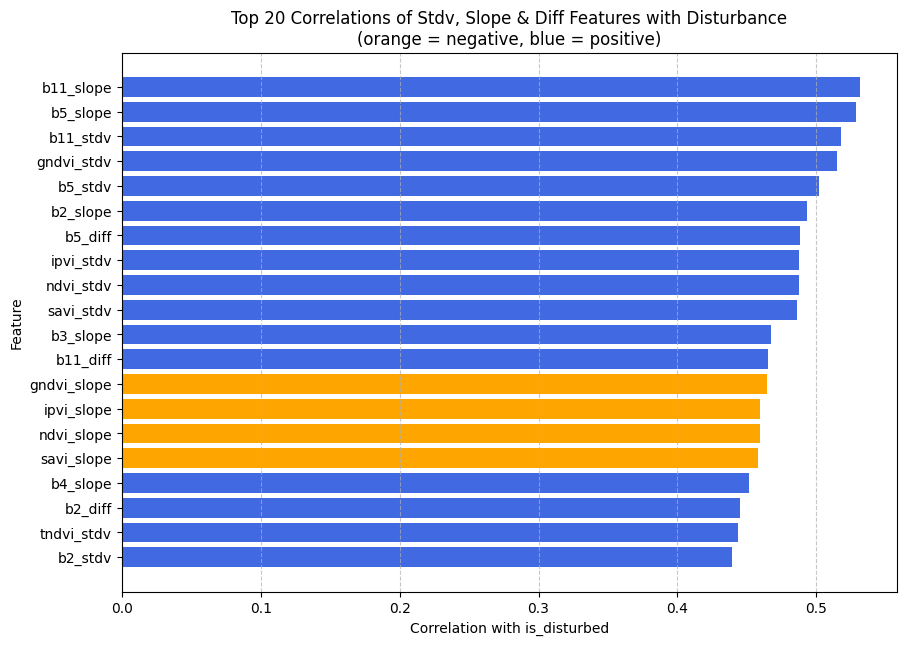

In [ ]:
corr_analyser.plot_correlations_with_target(correlations, top_n=20)

### Analysis of the significance of the features

In [ ]:
col = "b11"
slope_or_stdv = "slope"
df_std_slope[~df_std_slope["is_disturbed"]].sort_values(
    f"{col}_{slope_or_stdv}", ascending=False
)

# plot timeseries of id's with high slope or std to see if they are actually disturbed

,id,b2_std,b3_std,b4_std,b5_std,b6_std,b7_std,b8_std,b8a_std,b11_std,...,wdvi_slope,tndvi_slope,savi_slope,ipvi_slope,mcari_slope,reip_slope,masvi2_slope,dvi_slope,is_disturbed,disturbance_year
11875,11876,0.015522,0.023574,0.049952,0.041534,0.007538,0.014239,0.011697,0.007032,0.107883,...,-0.020929,-0.066923,-0.078240,-0.078245,-0.000389,-0.000026,0.000955,-0.029214,False,0.0
4605,4606,0.015251,0.018310,0.029489,0.027501,0.019603,0.019750,0.023394,0.020305,0.113322,...,0.005197,-0.034770,-0.050812,-0.050821,-0.000337,-0.000531,-0.000998,0.000147,False,0.0
26201,26202,0.013934,0.016201,0.027229,0.025218,0.014909,0.014042,0.016933,0.016095,0.109507,...,0.006116,-0.033149,-0.049112,-0.049133,-0.000436,-0.000431,-0.002051,0.001690,False,0.0
6176,6177,0.013941,0.016781,0.026801,0.025058,0.017302,0.016253,0.019201,0.018143,0.107465,...,0.006033,-0.034884,-0.051807,-0.051819,-0.000317,-0.000495,-0.001231,0.001570,False,0.0
509,510,0.015252,0.017624,0.029553,0.025671,0.017702,0.016185,0.018851,0.017604,0.108101,...,0.005557,-0.037962,-0.056059,-0.056070,-0.000495,-0.000349,-0.001196,0.000358,False,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19972,19973,0.004048,0.009329,0.012597,0.016100,0.031562,0.034840,0.043284,0.037841,0.032613,...,-0.002486,0.011874,0.014387,0.014389,-0.000146,0.000306,0.000100,0.000149,False,0.0
22319,22320,0.012512,0.014623,0.011250,0.016384,0.033185,0.037978,0.041252,0.037826,0.042537,...,-0.019970,0.000225,0.000366,0.000370,-0.000802,-0.000004,0.000564,-0.022735,False,0.0
14016,14017,0.031947,0.048587,0.061931,0.059145,0.054104,0.051903,0.054228,0.049897,0.048233,...,-0.019964,0.011382,0.012051,0.012039,0.000214,0.000054,0.000044,-0.001969,False,0.0
17513,17514,0.121576,0.119378,0.118368,0.117796,0.107294,0.103265,0.104693,0.099919,0.103603,...,-0.029082,0.010928,0.012766,0.012753,0.000216,-0.000017,0.000012,0.002351,False,0.0


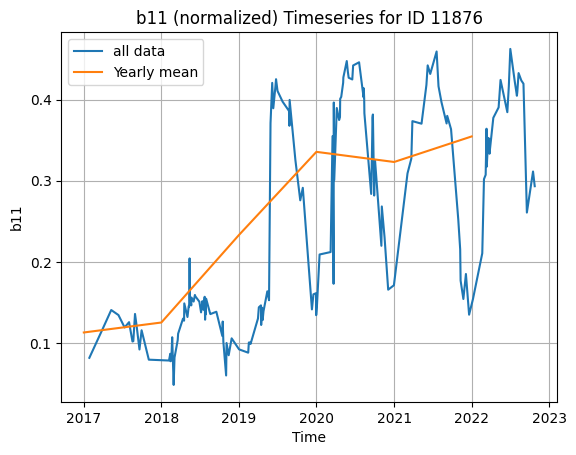

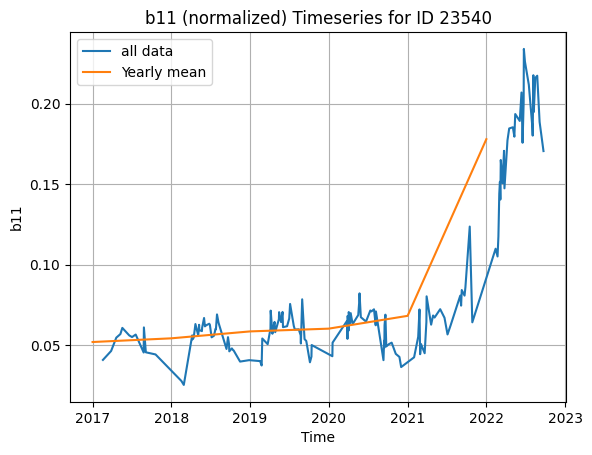

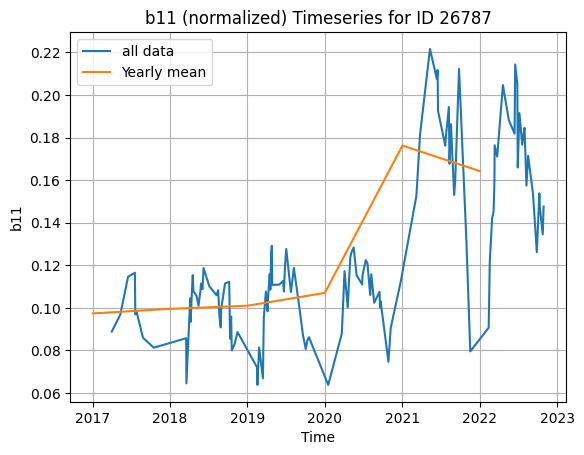

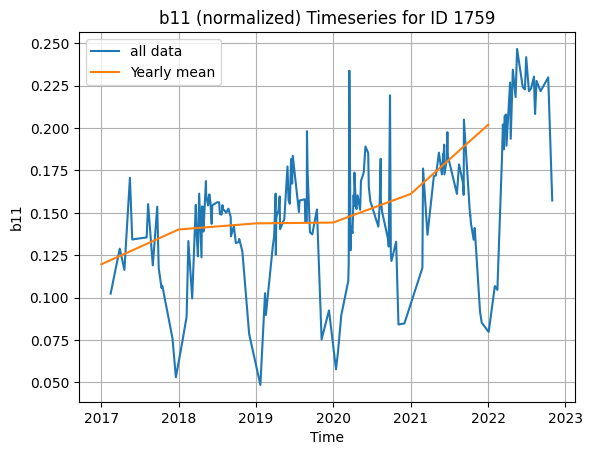

In [ ]:
# for different features many examples were plotted, like here for b11_slope:

plot_timeseries_oneid(df_scaled, 11876, "b11", df_yearly) # id with highest b11_slope (and not disturbed )
plot_timeseries_oneid(df_scaled, 23540, "b11", df_yearly) # id with the 300th highest b11_slope
plot_timeseries_oneid(df_scaled, 26787, "b11", df_yearly) # id with the 400th highest b11_slope
plot_timeseries_oneid(df_scaled, 1759, "b11", df_yearly) # id with the 550th highest b11_slope
# the last one is probably not disturbed

## Prepare Train-Data

Build training data from data with presumably correctly labeled data

In [59]:
disturbed_df = df_std_slope[df_std_slope["is_disturbed"]].copy()
healthy_df = df_std_slope[~df_std_slope["is_disturbed"]].copy()

In [60]:
top_features = ["b11_slope", "b5_slope", "b11_std", "gndvi_std"]
healthy_df["combi_top_features"] = healthy_df[top_features].mean(axis=1)
healthy_df.sort_values(by="combi_top_features")

,id,b2_std,b3_std,b4_std,b5_std,b6_std,b7_std,b8_std,b8a_std,b11_std,...,tndvi_slope,savi_slope,ipvi_slope,mcari_slope,reip_slope,masvi2_slope,dvi_slope,is_disturbed,disturbance_year,combi_top_features
12043,12044,0.003088,0.003261,0.007149,0.005418,0.006134,0.006345,0.007030,0.005714,0.003331,...,0.005097,0.005741,0.005737,0.000145,0.000027,2.150445e-05,-0.000048,False,0.0,0.000652
10951,10952,0.022716,0.022592,0.024803,0.019423,0.016529,0.015527,0.019662,0.016593,0.011202,...,0.000282,0.000224,0.000224,0.000288,-0.000072,8.544732e-06,0.001284,False,0.0,0.000733
15155,15156,0.000397,0.001539,0.000668,0.001931,0.006208,0.007066,0.006467,0.007664,0.001977,...,-0.001408,-0.002077,-0.002032,-0.000129,0.000073,9.736842e-06,-0.001759,False,0.0,0.000735
23144,23145,0.000601,0.000953,0.000389,0.000911,0.002480,0.002882,0.002695,0.003387,0.000899,...,0.000341,0.000537,0.000525,-0.000027,0.000009,-9.213511e-07,0.000469,False,0.0,0.000760
17446,17447,0.002315,0.002662,0.002019,0.001949,0.003682,0.003114,0.003856,0.003112,0.000826,...,-0.002279,-0.002378,-0.002376,-0.000022,0.000012,2.032380e-05,-0.001582,False,0.0,0.000821
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24990,24991,0.014754,0.017541,0.028682,0.025342,0.017278,0.016097,0.018597,0.017729,0.106960,...,-0.036920,-0.054713,-0.054724,-0.000499,-0.000347,-1.174447e-03,0.000714,False,0.0,0.062107
11875,11876,0.015522,0.023574,0.049952,0.041534,0.007538,0.014239,0.011697,0.007032,0.107883,...,-0.066923,-0.078240,-0.078245,-0.000389,-0.000026,9.549713e-04,-0.029214,False,0.0,0.062299
509,510,0.015252,0.017624,0.029553,0.025671,0.017702,0.016185,0.018851,0.017604,0.108101,...,-0.037962,-0.056059,-0.056070,-0.000495,-0.000349,-1.196120e-03,0.000358,False,0.0,0.062560
4605,4606,0.015251,0.018310,0.029489,0.027501,0.019603,0.019750,0.023394,0.020305,0.113322,...,-0.034770,-0.050812,-0.050821,-0.000337,-0.000531,-9.984114e-04,0.000147,False,0.0,0.062853


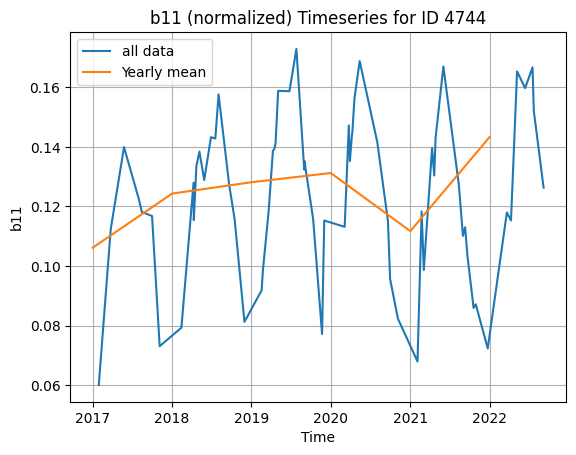

In [64]:
plot_timeseries_oneid(df_scaled, 4744, "b11", df_yearly)

- Idea: Healthy df with 10,000 data points that are almost certainly not disturbed
- the four top features must have a low value

- Testing of random samples showed that the first 20,000 rows of healthy_df should not be disturbed trees.

In [65]:
healthy_df_sub = (
    healthy_df.sort_values(by="combi_top_features")
    .head(20000)
    .sample(n=10000, random_state=42)
)

# Using .head(10000) slightly worsened model performance, so a random sample of the first 20.000 rows was used instead

train_df = (
    pd.concat([disturbed_df, healthy_df_sub])
    .sample(frac=1, random_state=42)
    .reset_index(drop=True)
)

print("Disturbed:", len(disturbed_df))
print("Healthy (balanced):", len(healthy_df_sub))
print("Training set total:", len(train_df))

Disturbed: 3630
Healthy (balanced): 10000
Training set total: 13630
